In [1]:
import numpy as np
import pyscf
from kspies import wy, util
import matplotlib.pyplot as plt
import xray_help
import basis_set_exchange
import MolecGeom as geom

* XRayHelp Warning * Adcc is not available.
* XRayHelp Warning * VeloxChem is not available.
* XRayHelp Warning * Pandas is not available.

Could not import geomeTRIC!!!



In [2]:
name = "n2"
regularization = 0

In [3]:
mymol = geom.Geometry()
mymol.new_read_xyz(name+".xyz")
mymol.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
help(basis_set_exchange.api.get_basis)

Help on function get_basis in module basis_set_exchange.api:

get_basis(name, elements=None, version=None, fmt=None, uncontract_general=False, uncontract_spdf=False, uncontract_segmented=False, remove_free_primitives=False, make_general=False, optimize_general=False, augment_diffuse=0, augment_steep=0, get_aux=0, data_dir=None, header=True)
    Obtain a basis set
    
    This is the main function for getting basis set information.
    This function reads in all the basis data and returns it either
    as a string or as a python dictionary.
    
    Parameters
    ----------
    name : str
        Name of the basis set. This is not case sensitive.
    elements : str or list
        List of elements that you want the basis set for.
        Elements can be specified by Z-number (int or str) or by symbol (str).
        If this argument is a str (ie, '1-3,7-10'), it is expanded into a list.
        Z numbers and symbols (case insensitive) can be used interchangeably
        (see :func:`bas

In [5]:
basis_name = "cc-pvtz" #"cc-pvtz" #"aug-cc-pvqz" #"aug-cc-pvqz"

if "unc" in basis_name:
    basis_set = basis_name
else:
    uncontract_general=False
    basis_set = {}
    for atom in mymol.list:
        basis_txt = basis_set_exchange.api.get_basis(basis_name, augment_diffuse=0, uncontract_general=uncontract_general,
                                                     elements=atom.symbol, fmt="nwchem")
        basis = pyscf.gto.load(basis_txt, atom.symbol)
        basis_set[atom.symbol] = basis

    if uncontract_general:
        basis_name = "uctrgen-" + basis_name

In [6]:
molecule = xray_help.build_molecule(name + ".xyz", basis=basis_set)

In [7]:
molecule.bas_exps()

[array([1.142e+04, 1.712e+03, 3.893e+02, 1.100e+02, 3.557e+01, 1.254e+01,
        4.644e+00, 1.293e+00, 5.118e-01, 1.787e-01]),
 array([26.63  ,  5.948 ,  1.742 ,  0.555 ,  0.1725]),
 array([1.654, 0.469]),
 array([1.093]),
 array([1.142e+04, 1.712e+03, 3.893e+02, 1.100e+02, 3.557e+01, 1.254e+01,
        4.644e+00, 1.293e+00, 5.118e-01, 1.787e-01]),
 array([26.63  ,  5.948 ,  1.742 ,  0.555 ,  0.1725]),
 array([1.654, 0.469]),
 array([1.093])]

In [8]:
functional = "PBE,"
guide = "GGA_X_PBE" #functional

In [9]:
pyscf_drv = pyscf.scf.RKS(molecule)
pyscf_drv.xc = functional
pyscf_drv.verbose = 4
pyscf_drv.grids.level = 6
print("Grid level: ", pyscf_drv.grids.level)
pyscf_drv.kernel()

Grid level:  6


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpeertv26v
max_memory 4000 MB (current use 156 MB)
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = PBE,
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
small_rho_cutoff = 1e-07
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
init E= -109.148569391102
  HOMO = -0.335925157422073  LUMO = -0.0133941837037015
cycle= 1 E= -108.993939727369  delta_E= 0.155  |g|= 0.0858  |ddm|= 3.25
  HOMO = -

-108.99514987121293

In [10]:
# pyscf_drv = pyscf.scf.RHF(molecule)
# pyscf_drv.verbose = 4
# pyscf_drv.kernel()

In [11]:
# pyscf_drv.analyze()

In [12]:
ni = pyscf_drv._numint
# xctype = ni._xc_type(pyscf_drv.xc)

In [13]:
dm_0 = pyscf_drv.make_rdm1()

In [14]:
coords = np.array([np.array((x, 0., 0.)) for x in np.linspace(-5, 5, 5001)])

In [15]:
coords.shape

(5001, 3)

In [16]:
#WY calculations
mw = wy.RWY(molecule, dm_0)
mw.guide = guide
mw.method = 'SLSQP'
mw.reg = regularization
mw.tol = 1e-6

In [17]:
if guide == "FAXC":
    xctype = "FAXC"
elif guide == "Slater":
    xctype = "LDA"
else:
    xctype = "GGA"

In [18]:
pb = pyscf.dft.numint.eval_ao(mw.pmol, coords) # potential basis values on grid

if xctype == "GGA":
    vg = util.eval_vxc(molecule, dm_0, mw.guide, coords) # guiding potential on grid
elif xctype == "FAXC":
    dmxc = 1.0/molecule.nelectron * dm_0
    vg = util.eval_vh(molecule, coords, dmxc) # guiding potential on grid
else:
    dm_on_grid = pyscf.dft.numint.eval_rho(molecule, pb,
                                           dm_0, xctype='LDA')
    vg = ni.eval_xc_eff(guide, dm_on_grid, deriv=1)[1]

In [19]:
epsilon = 5e-7
delta_rho = epsilon * np.diag(np.ones(dm_0.shape[0]))
dm_plus = dm_0 + delta_rho
dm_minus = dm_0 - delta_rho

In [20]:
if xctype == 'GGA':
    vg_plus = util.eval_vxc(molecule, dm_plus, mw.guide, coords) # guiding potential on grid
    vg_minus = util.eval_vxc(molecule, dm_minus, mw.guide, coords) # guiding potential on grid
elif xctype == "FAXC":
    dmxc_plus = 1.0/molecule.nelectron * dm_plus
    vg_plus = util.eval_vh(molecule, coords, dmxc_plus) # guiding potential on grid
    dmxc_minus = 1.0/molecule.nelectron * dm_minus
    vg_minus = util.eval_vh(molecule, coords, dmxc_minus) # guiding potential on grid
else:
    print(xctype)
    dm_plus_on_grid = pyscf.dft.numint.eval_rho(molecule, pb,
                                           dm_plus, xctype='LDA')
    dm_minus_on_grid = pyscf.dft.numint.eval_rho(molecule, pb,
                                           dm_minus, xctype='LDA')
    vg_plus = ni.eval_xc_eff(guide, dm_plus_on_grid, deriv=1)[1]
    vg_minus = ni.eval_xc_eff(guide, dm_minus_on_grid, deriv=1)[1]

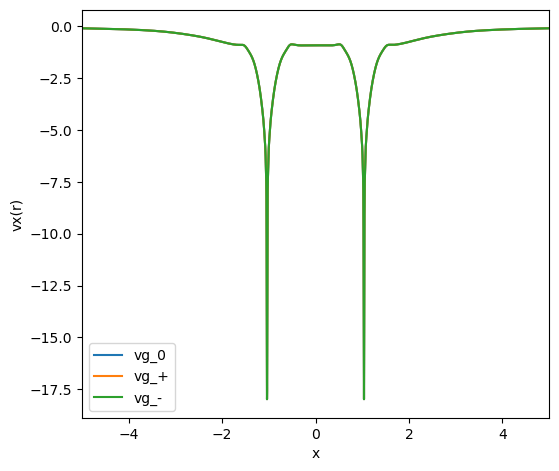

In [21]:
plt.figure()

if xctype == "GGA" or xctype == "FAXC":
    plt.plot(coords[:,0], vg, label="vg_0")
    plt.plot(coords[:,0], vg_plus, label="vg_+")
    plt.plot(coords[:,0], vg_minus, label="vg_-")
else:
    plt.plot(coords[:,0], vg[0,:], label="vg_0")
    plt.plot(coords[:,0], vg_plus[0,:], label="vg_+")
    plt.plot(coords[:,0], vg_minus[0,:], label="vg_-")

plt.xlabel("x")
plt.ylabel("vx(r)")
plt.xlim(-5, 5)
#plt.ylim(-10, 0)
plt.legend()
plt.subplots_adjust(left=0.2, right=0.93, bottom=0.12, top=0.97)
plt.show()

In [22]:
print(vg_plus - vg_minus)

[-1.31402372e-07 -1.31213466e-07 -1.31082742e-07 ... -1.31069856e-07
 -1.31209801e-07 -1.31420614e-07]


In [23]:
# plt.figure()

# if xctype == "GGA":
#     plt.plot(coords[:,0], vg_plus - vg_minus, label="vg+ - vg-")
# else:
#     plt.plot(coords[:,0], vg_plus[0,:] - vg_minus[0,:], label="vg+ - vg-")

# plt.xlabel("x")
# plt.ylabel("vx(r)")
# plt.xlim(-5, 5)
# # plt.ylim(-5, 0)
# plt.legend()
# plt.subplots_adjust(left=0.2, right=0.93, bottom=0.12, top=0.97)
# plt.show()

In [42]:
regularization

0

In [43]:
mw_plus = wy.RWY(molecule, dm_plus)
mw_plus.guide = guide
mw_plus.tol = 1e-6
mw_plus.method = 'trust-exact'
mw_plus.reg = regularization
#pb_plus = pyscf.dft.numint.eval_ao(mw_plus.pmol, coords)
mw_plus.run()
vc_plus = np.einsum('t,rt->r', mw_plus.b, pb)

In [44]:
mw_minus = wy.RWY(molecule, dm_minus)
mw_minus.guide = guide
mw_minus.tol = 1e-6
mw_minus.method = 'trust-exact'
mw_minus.reg = regularization # 0
#pb_minus = pyscf.dft.numint.eval_ao(mw_minus.pmol, coords)
mw_minus.run()
vc_minus = np.einsum('t,rt->r', mw_minus.b, pb)

In [45]:
ao_values = pyscf.dft.numint.eval_ao(molecule, coords,
                                     deriv = 0)

In [46]:
print(ao_values - pb)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
delta_rho_on_grid_x = pyscf.dft.numint.eval_rho(molecule, pb,
                                                delta_rho, xctype='LDA')

In [48]:
drho = np.einsum("mn,gm,gn->g", delta_rho, ao_values, ao_values)

In [49]:
print(delta_rho_on_grid_x - drho)

[0. 0. 0. ... 0. 0. 0.]


In [50]:
#delta_rho_on_grid_x

In [51]:
fxc_symm = (vg_plus[0] + vc_plus - vg_minus[0] - vc_minus) / ( 2 * delta_rho_on_grid_x )

In [52]:
# plt.figure()

# if xctype == "GGA":
#     plt.plot(coords[:,0], vg_plus, label="vg+")
#     plt.plot(coords[:,0], vg_minus, label="vg-")

#     plt.plot(coords[:,0], vc_plus, label="vc+")
# else:
#     #plt.plot(coords[:,0], vg_plus[0] - vg_minus[0], label="vg+ - vg-")
#     plt.plot(coords[:,0], vc_plus - vc_minus, label="vc+ - vc-")

# plt.xlabel("x")
# plt.ylabel("diff vx(r)")
# plt.xlim(0, 3)
# # plt.ylim(-5, 0)
# plt.legend()
# plt.subplots_adjust(left=0.2, right=0.93, bottom=0.12, top=0.97)
# plt.show()

In [53]:
# if xctype == 'LDA':
#     fxc_analytical = ( -1.0/3.0 * ( 3.0 / np.pi )**(1.0/3.0) 
#                   * dm_on_grid**(-2.0/3.0) 
#                  )
grid = pyscf_drv.grids.copy()
grid.coords = coords
grid.weights = np.ones((coords.shape[0]))
fxc_pyscf = ni.cache_xc_kernel1(molecule, grid, pyscf_drv.xc, dm_0, spin=0)[2]

In [54]:
fxc_pyscf.shape

(4, 4, 5001)

In [55]:
# np.save("n2_cc_pvtz_Slater_num_fxc.npy", fxc_symm)
#slater_fxc = np.load("n2_cc_pvtz_Slater_num_fxc.npy")

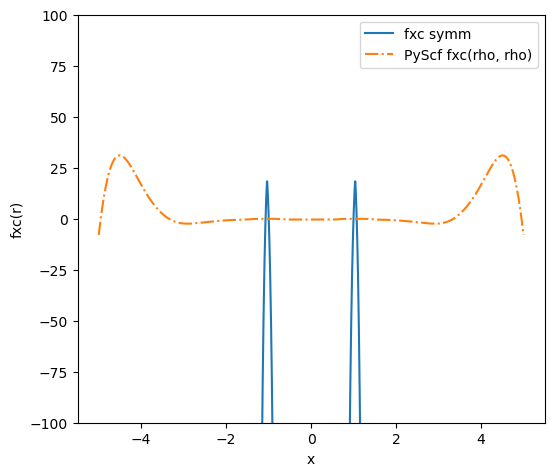

In [58]:
plt.figure()

#print(pyscf_drv.xc, xctype)

plt.plot(coords[:,0], fxc_symm, label="fxc symm")
#plt.plot(coords[:, 0], slater_fxc, label="Slater num fxc")

plt.plot(coords[:,0], fxc_pyscf[0, 0], "-.", label="PyScf fxc(rho, rho)")
#plt.plot(coords[:,0], np.sum(np.sum(fxc_pyscf, axis=0), axis=0), "--", label="PyScf sum")

plt.xlabel("x")
plt.ylabel("fxc(r)")
# plt.xlim(-5, 5)
plt.ylim(-100, 100)
plt.legend()
plt.subplots_adjust(left=0.2, right=0.93, bottom=0.12, top=0.97)
plt.show()

NameError: name 'slater_fxc' is not defined

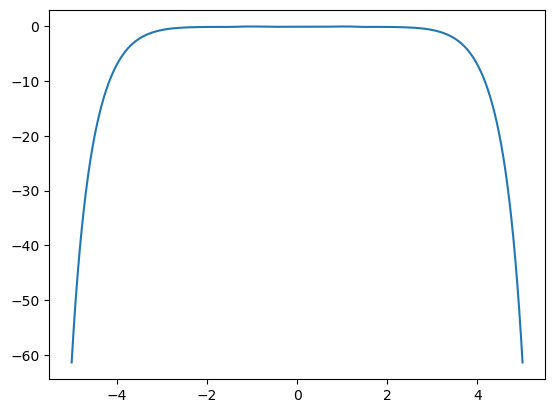

In [40]:
plt.figure()

#print(pyscf_drv.xc, xctype)

plt.plot(coords[:,0], fxc_symm, label="fxc symm")
plt.plot(coords[:, 0], slater_fxc, label="Slater num fxc")
if xctype == 'LDA':
    plt.plot(coords[:,0], fxc_analytical, "--", label="analytical fxc")

#plt.plot(coords[:,0], fxc_pyscf[0, 0], "-.", label="PyScf fxc(rho, rho)")
#plt.plot(coords[:,0], np.sum(np.sum(fxc_pyscf, axis=0), axis=0), "--", label="PyScf sum")

plt.xlabel("x")
plt.ylabel("fxc(r)")
# plt.xlim(-5, 5)
# plt.ylim(-5, 0)
plt.legend()
plt.subplots_adjust(left=0.2, right=0.93, bottom=0.12, top=0.97)
plt.show()

# Full DFT grid and absorption

In [41]:
ao_values = pyscf.dft.numint.eval_ao(molecule, pyscf_drv.grids.coords)

NameError: name 'xc_pyscf_drv' is not defined

In [79]:
dm_0

NPArrayWithTag([[ 1.99985,  0.00165, -0.02202, ..., -0.00077,  0.     ,
                  0.001  ],
                [ 0.00165,  0.00002, -0.00166, ..., -0.00003,  0.     ,
                  0.00005],
                [-0.02202, -0.00166,  1.7233 , ...,  0.00398, -0.     ,
                 -0.00513],
                ...,
                [-0.00077, -0.00003,  0.00398, ...,  0.00006, -0.     ,
                 -0.00008],
                [ 0.     ,  0.     , -0.     , ..., -0.     ,  0.00008,
                 -0.     ],
                [ 0.001  ,  0.00005, -0.00513, ..., -0.00008, -0.     ,
                  0.0001 ]])

In [51]:
if xctype == 'GGA':
    print(xctype)
    vg_plus = util.eval_vxc(molecule, dm_plus, mw.guide, pyscf_drv.grids.coords) # guiding potential on grid
    vg_minus = util.eval_vxc(molecule, dm_minus, mw.guide, pyscf_drv.grids.coords) # guiding potential on grid
else:
    print(xctype)
    dm_plus_on_grid = pyscf.dft.numint.eval_rho(molecule, ao_values,
                                           dm_plus, xctype='LDA')
    dm_minus_on_grid = pyscf.dft.numint.eval_rho(molecule, ao_values,
                                           dm_minus, xctype='LDA')
    vg_plus = ni.eval_xc_eff(xc_pyscf_drv.xc, dm_plus_on_grid, deriv=1)[1]
    vg_minus = ni.eval_xc_eff(xc_pyscf_drv.xc, dm_minus_on_grid, deriv=1)[1]

LDA


In [52]:
delta_rho_on_grid = pyscf.dft.numint.eval_rho(molecule, ao_values,
                                              delta_rho, xctype='LDA')
dm_on_full_grid = pyscf.dft.numint.eval_rho(molecule, ao_values,
                                            dm_0, xctype='LDA')

In [53]:
if xctype == 'LDA':
    fxc_analytical_full = ( -1.0/3.0 * ( 3.0 / np.pi )**(1.0/3.0) 
                  * dm_on_full_grid**(-2.0/3.0) 
                 )

In [54]:
vc_plus = np.einsum('t,rt->r', mw_plus.b, ao_values)
vc_minus = np.einsum('t,rt->r', mw_minus.b, ao_values)

In [55]:
print(vg_plus.shape, vc_plus.shape, vg_minus.shape, vc_minus.shape, delta_rho_on_grid.shape)

(1, 108592) (108592,) (1, 108592) (108592,) (108592,)


In [56]:
if xctype == 'LDA':
    print(xctype, vg_plus.shape, vc_plus.shape, vg_minus.shape, vc_minus.shape, delta_rho_on_grid.shape)
    fxc_symm_full = (vg_plus[0] + vc_plus - vg_minus[0] - vc_minus) / (2 * delta_rho_on_grid)
else:
    print(xctype, vg_plus.shape, vc_plus.shape, vg_minus.shape, vc_minus.shape, delta_rho_on_grid.shape)
    fxc_symm_full = (vg_plus + vc_plus - vg_minus - vc_minus) / (2 * delta_rho_on_grid)

LDA (1, 108592) (108592,) (1, 108592) (108592,) (108592,)


In [57]:
print(np.max(np.abs(vg_plus + vc_plus - vg_minus - vc_minus)))

0.00030918305904537036


In [58]:
diag_dict = xray_help.absorption_by_E2_matrix_diagonalization(molecule, pyscf_drv, tda=True)

['/home/emi/miniconda3/envs/wu-yang-env/lib/python3.9/site-packages/pyscf']
User defined fxc: None


In [59]:
fxc_symm_full.shape

(108592,)

In [60]:
correction = 1.0
diag_dict_num = xray_help.absorption_by_E2_matrix_diagonalization(molecule, pyscf_drv, tda=True, fxc=correction*fxc_symm_full)

['/home/emi/miniconda3/envs/wu-yang-env/lib/python3.9/site-packages/pyscf']
User defined fxc: [ -2260107.71575918  -6656706.96120614 -24621953.20182044 ...
 -24134490.55710226 -24134490.55648264 -25421328.67085864]


In [61]:
if xctype == 'LDA':
    diag_dict_analytic = xray_help.absorption_by_E2_matrix_diagonalization(molecule, pyscf_drv, tda=True, fxc=fxc_analytical_full)

['/home/emi/miniconda3/envs/wu-yang-env/lib/python3.9/site-packages/pyscf']
User defined fxc: [  -740025.65313811  -2796960.34311533 -13127665.54434882 ...
 -13165045.04840162 -13165045.04840172 -13014643.61907135]


In [62]:
E2_num = diag_dict_num['E2']
E2 = diag_dict['E2']
if xctype == 'LDA':
    E2_ana = diag_dict_analytic['E2']

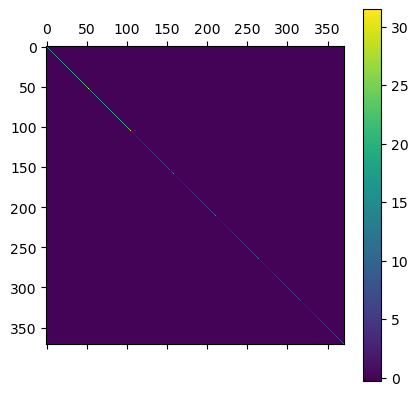

In [63]:
if E2.shape[0] < 20:
    fig, ax = plt.subplots()
    ax.matshow(E2)
    for (i, j), z in np.ndenumerate(E2):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
else:
    plt.matshow(E2)
    plt.colorbar()
plt.show()

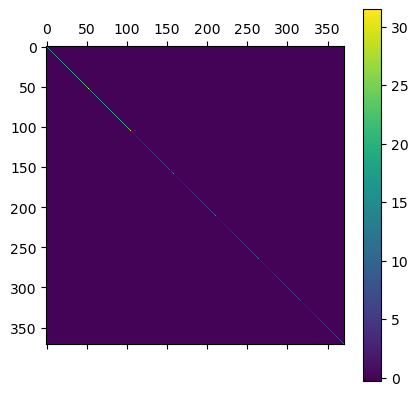

In [64]:
if E2_num.shape[0] < 20:
    fig, ax = plt.subplots()
    ax.matshow(E2_num)
    for (i, j), z in np.ndenumerate(E2_num):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
else:
    plt.matshow(E2_num)
    plt.colorbar()
plt.show()

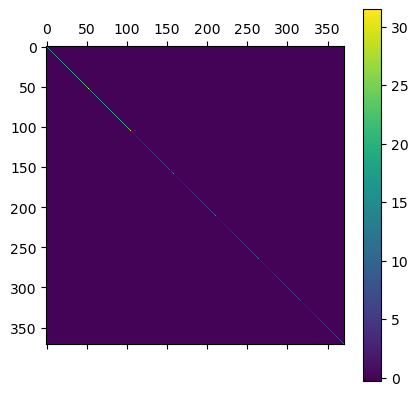

In [65]:
if xctype == 'LDA':
    if E2_ana.shape[0] < 20:
        fig, ax = plt.subplots()
        ax.matshow(E2_ana)
        for (i, j), z in np.ndenumerate(E2_ana):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    else:
        plt.matshow(E2_ana)
        plt.colorbar()
    plt.show()

In [66]:
help(xray_help.absorption_spectrum_tdscf)

Help on function absorption_spectrum_tdscf in module xray_help:

absorption_spectrum_tdscf(scf_gs, nstates=5, cvs_space=None, tda=False)
    Computes the absorption spectrum using TDDFT.
    
             a restricted reference state.
    
    :param scf_gs   : the SCF reference state (for CVS, restricted only).
    :param nstates  : the number of transitions (roots).
    :param tda      : if to use the Tamm-Dancoff approximation.
    :param cvs_space: a list of core orbital indices
                      for the CVS approximation.



In [67]:
# tda_drv = pyscf.tdscf.TDA(pyscf_drv)
# tda_drv.nstates = 30
# tda_results = tda_drv.kernel()

In [68]:
# tda_drv.analyze()

In [69]:
index = 0
print(diag_dict['eigenvalues'][index] * xray_help.hartree_in_ev(), diag_dict['oscillator strengths'][index])

8.515676138250873 3.412162427803735e-30


In [70]:
np.set_printoptions(suppress=True, precision=5)
print(diag_dict['oscillator strengths'])

[0.      0.      0.      0.      0.      0.21486 0.21486 1.27799 0.76681
 0.      0.      0.      0.      0.      0.      0.14866 0.14866 0.248
 0.248   0.29895 0.29895 0.      0.      0.      0.      0.      0.
 0.      0.00515 0.      0.20443 0.      0.      0.      0.      0.0278
 0.      0.      0.14182 0.14182 0.      0.      0.      0.      0.05767
 0.      0.      0.      1.33726 1.33726 0.      0.      1.19238 0.
 0.      0.      0.      0.88187 0.88187 0.      0.27528 0.33584 0.33584
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.43077 0.      0.      0.03887
 0.03887 0.      0.      0.      0.18211 0.      0.      0.      0.2141
 0.00006 0.00006 0.0197  0.19106 0.19106 0.      0.      0.03673 0.
 0.      0.      0.      0.      0.      0.18748 0.      0.      0.
 0.06613 0.06613 0.      0.      0.      0.0048  0.0048  0.      0.11355
 0.      0.      0.      0.      0.      0.0132  0.18183 0.18183 0.
 0.      0. 

In [71]:
diag_dict_num['eigenvalues']

array([ 0.31295,  0.33348,  0.33348,  0.36834,  0.36834,  0.58114,
        0.58114,  0.60312,  0.75521,  0.76068,  0.76068,  0.81368,
        0.81368,  0.81519,  0.82068,  0.83975,  0.83975,  0.8604 ,
        0.8604 ,  0.91092,  0.91092,  0.93355,  0.9403 ,  0.9403 ,
        0.9812 ,  0.98877,  0.98877,  0.99083,  1.01865,  1.02951,
        1.03983,  1.06563,  1.06563,  1.10546,  1.10546,  1.14214,
        1.16856,  1.16856,  1.182  ,  1.182  ,  1.22802,  1.22802,
        1.2641 ,  1.2641 ,  1.30928,  1.32   ,  1.32   ,  1.32921,
        1.34985,  1.34985,  1.41548,  1.41548,  1.42463,  1.51854,
        1.52436,  1.52436,  1.5245 ,  1.59919,  1.59919,  1.61457,
        1.63813,  1.68091,  1.68091,  1.70905,  1.70905,  1.71031,
        1.71031,  1.72744,  1.75324,  1.7662 ,  1.7662 ,  1.77535,
        1.77535,  1.83979,  1.83979,  1.91613,  1.91613,  1.96708,
        2.06351,  2.06351,  2.15859,  2.15859,  2.16137,  2.16137,
        2.16788,  2.16887,  2.20004,  2.20004,  2.20248,  2.21

In [72]:
if xctype == 'LDA':
    print(diag_dict_analytic['eigenvalues'])

[ 0.31295  0.33348  0.33348  0.36834  0.36834  0.58114  0.58114  0.60312
  0.75521  0.76068  0.76068  0.81368  0.81368  0.81519  0.82068  0.83975
  0.83975  0.8604   0.8604   0.91092  0.91092  0.93355  0.9403   0.9403
  0.9812   0.98877  0.98877  0.99083  1.01865  1.02951  1.03983  1.06563
  1.06563  1.10546  1.10546  1.14214  1.16856  1.16856  1.182    1.182
  1.22802  1.22802  1.2641   1.2641   1.30928  1.32     1.32     1.32921
  1.34985  1.34985  1.41548  1.41548  1.42463  1.51854  1.52436  1.52436
  1.5245   1.59919  1.59919  1.61457  1.63813  1.68091  1.68091  1.70905
  1.70905  1.71031  1.71031  1.72744  1.75324  1.7662   1.7662   1.77535
  1.77535  1.83979  1.83979  1.91613  1.91613  1.96708  2.06351  2.06351
  2.15859  2.15859  2.16137  2.16137  2.16788  2.16887  2.20004  2.20004
  2.20248  2.21561  2.32032  2.32032  2.33838  2.39013  2.39013  2.39022
  2.39022  2.49677  2.54493  2.54493  2.59338  2.99933  2.99992  2.99992
  3.24807  3.25068  3.25068  3.25285  3.25749  3.25749

In [73]:
max_diff = np.max(np.abs(diag_dict['eigenvalues'] - diag_dict_num['eigenvalues'])*xray_help.hartree_in_ev())
rel_diff = (diag_dict['eigenvalues'] - diag_dict_num['eigenvalues']) * 100 / diag_dict['eigenvalues']
rel_diff_osc = (diag_dict['oscillator strengths'] - diag_dict_num['oscillator strengths']) * 100 / diag_dict['eigenvalues']

indices = np.where(np.abs((diag_dict['eigenvalues'] - diag_dict_num['eigenvalues'])*xray_help.hartree_in_ev()) == max_diff)
print(max_diff, indices, 
      diag_dict['oscillator strengths'][indices[0]], diag_dict_num['oscillator strengths'][indices[0]],
      diag_dict['eigenvalues'][indices[0]], diag_dict_num['eigenvalues'][indices[0]])

0.0 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [74]:
np.max(np.abs(E2-E2_num))

0.0

In [75]:
x, y = xray_help.add_broadening(diag_dict['eigenvalues'] * xray_help.hartree_in_ev(),
                                diag_dict['oscillator strengths'], step=0.1, line_param=0.5, interval=(0, 50))
xn, yn = xray_help.add_broadening(diag_dict_num['eigenvalues'] * xray_help.hartree_in_ev(),
                                  diag_dict_num['oscillator strengths'], step=0.1, line_param=0.5, interval=(0, 50))
if xctype == 'LDA':
    xa, ya = xray_help.add_broadening(diag_dict_analytic['eigenvalues'] * xray_help.hartree_in_ev(),
                                      diag_dict_analytic['oscillator strengths'], step=0.1, line_param=0.5)

In [76]:
if regularization == 0:
    reg_txt = ""
else:
    reg_txt = "reg%.1e" % regularization
svg_name = name + "_" + functional + "_" + basis_name + "_" + reg_txt
title = name + ", " + functional + "/" + basis_name +", TDA absorption spectrum, WY " + reg_txt

In [77]:
title

'n2, Slater/cc-pvtz, TDA absorption spectrum, WY '

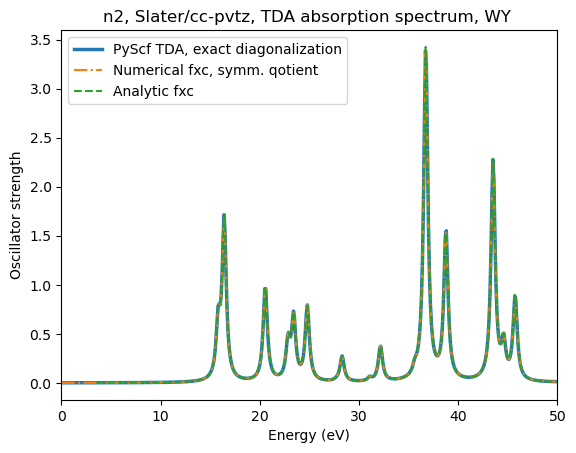

In [78]:
plt.figure()
plt.plot(x, y, label="PyScf TDA, exact diagonalization", linewidth=2.5)
plt.plot(xn, yn, "-.", label="Numerical fxc, symm. qotient")
if xctype == 'LDA':
    plt.plot(xa, ya, "--", label="Analytic fxc")
plt.title(title)
plt.xlabel("Energy (eV)")
plt.ylabel("Oscillator strength")
plt.legend()
plt.axis(xmin=0, xmax=50)
#plt.savefig(svg_name + ".svg")
plt.show()

In [ ]:
# plt.figure()
# plt.plot(x, y-yn, label="PyScf fxc - num fxc, TDA, exact diagonalization")
# #plt.plot(xn, yn, "-.", label="Numerical fxc, symm. qotient")
# plt.title(name + ", " + functional + "/" + basis_name +", TDA absorption spectrum")
# plt.xlabel("Energy (eV)")
# plt.ylabel("Oscillator strength")
# plt.legend()
# plt.savefig(name + "_" + functional + "_" + basis_name + "_diff.svg")
# plt.show()

In [ ]:
plt.figure()
plt.bar(diag_dict['eigenvalues']*xray_help.hartree_in_ev(), rel_diff)
plt.title(title)
plt.xlabel("Energy (eV)")
plt.ylabel("Relative difference (%)")
# plt.axis(xmin=0, xmax=50) #, ymin=-5, ymax=0.1)
#plt.savefig(svg_name + "_reldiff.svg")
plt.show()

In [ ]:
plt.figure()
plt.bar(diag_dict['eigenvalues']*xray_help.hartree_in_ev(), rel_diff_osc)
plt.title(title)
plt.xlabel("Energy (eV)")
plt.ylabel("Relative difference (%)")
# plt.axis(xmin=0, xmax=50) #, ymin=-5, ymax=0.1)
#plt.savefig(svg_name + "_reldiff.svg")
plt.show()